## Santa Fe Fireshed
### Output figure generation


In [529]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib import colors


# ---- Geospatial utilities
from geoUtils import *
from NECN_utils import *

dataDir = 'V:/SFFireshed/'
simsDir = 'V:/SantaFe_Fireshed_Sims/'
rasters = dataDir + 'InputRasters/'


### We need to build the framework for plots to be generated from
This generally means listing the names of simulations, or pointing to directories that hold the data that we need to access the info from specific sim, etc. This will ultimately turn into a more complicated list of different climates and treatment combinations, allowing us to ack more questions, with greater confidence.

In [614]:
testingSims = ['ExtremeFW_HistoricClimate_Sims']
mgmtSims = ['SFF_Mgmt']
nullSims = ['SFF_CNRM_Projected_NoMan']

submitSims = ['SFF_Mgmt',
           'SFF_CNRM_Projected_NoMan']

allSims = ['ExtremeFW_HistoricClimate_Sims',
           'SFF_Mgmt',
           'SFF_CNRM_Projected_NoMan']

### Intro and background figures
These are largely recreated from the prep notebook, and just curated to look a little better, with labels, etc.

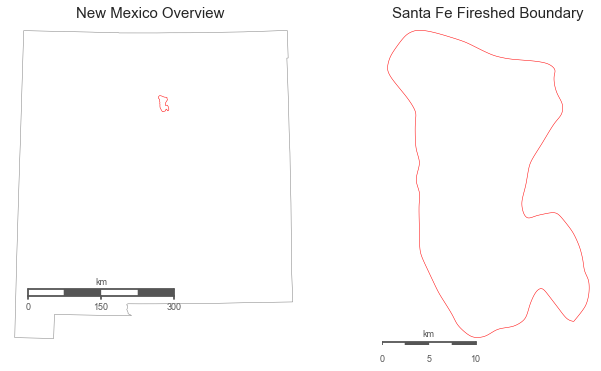

In [530]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
coords, midlat, midlon = getShpGeom(dataDir + 'NM_NAD83.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(dataDir + 'NM_NAD83', 'NewMexico',
    color='gray', zorder=5);
m.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'SFFireshed',
    color='red', zorder=5);

m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(dataDir + 'GSFCC_Boundary_NAD83.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'GSFCC',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.055, coords[1] + 0.00,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('New Mexico Overview', fontsize = 15)
ax2.set_title('Santa Fe Fireshed Boundary', fontsize = 15)
plt.tight_layout()
sns.set_style('white')
sns.despine(left = True, bottom = True)

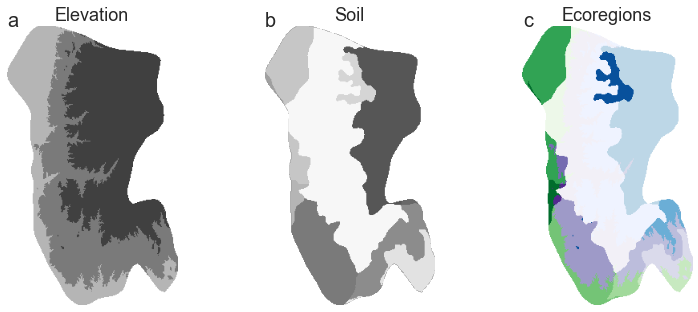

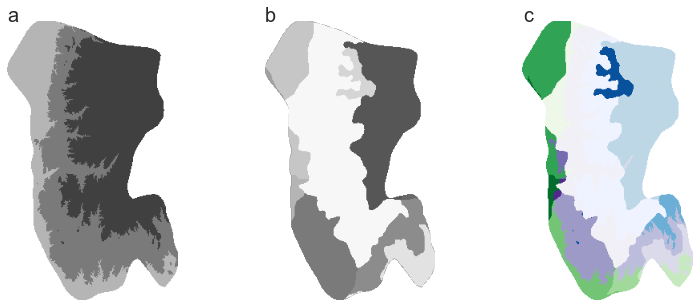

In [576]:
elevation  = importRaster(rasters + 'SFF_FireRegions.tif')
soils      = importRaster(rasters + 'soilBins.tif')
ecoregions = importRaster(rasters + 'SFF_ecoregionsV2.tif')
soils[soils > 12] = np.nan

cmap = colors.ListedColormap(['white','#969696','#636363',
                              '#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c',
                              '#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f',
                              '#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'])
bounds=[0,105,106,
        201,202,203,204,205,206,
        301,302,303,304,305,306,
        401,402,403,404,406]
norm = colors.BoundaryNorm(bounds, cmap.N)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)

plotRaster(elevation,  vmin = 0, vmax = 500, ax = ax1)
plotRaster(soils,      vmin = 0, vmax = 15,  ax = ax2)
plotRaster(ecoregions, cmap = cmap, norm = norm, ax = ax3)
ax1.text(0, .4, 'a',  fontsize=20)
ax2.text(1, .4, 'b',  fontsize=20)
ax3.text(2.1, .4, 'c', fontsize=20)

ax1.set_title('Elevation')
ax2.set_title('Soil')
ax3.set_title('Ecoregions')
plt.savefig('Figure2.tif', dpi = 150)

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)

plotRaster(elevation,  vmin = 0, vmax = 500, ax = ax1)
plotRaster(soils,      vmin = 0, vmax = 15,  ax = ax2)
plotRaster(ecoregions, cmap = cmap, norm = norm, ax = ax3)
ax1.text(0, .4, 'a',  fontsize=20)
ax2.text(1, .4, 'b',  fontsize=20)
ax3.text(2.1, .4, 'c', fontsize=20)

plt.savefig('Figure2_notitle.tif', dpi = 150)

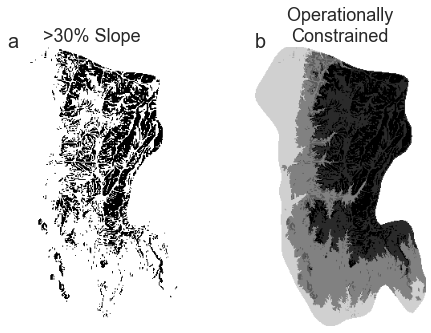

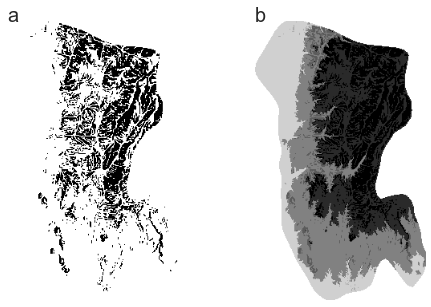

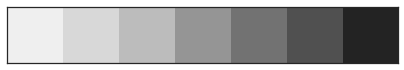

In [612]:
slopemask = importRaster(rasters + 'SFF_Slope.tif')
conMgmt = importRaster(rasters + 'SFF_ConManagement.tif')
slopemask[slopemask > 30] = 50
slopemask[slopemask <= 30] = 0

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)

plotRaster(slopemask,  vmin = 0, vmax = 50, ax = ax1)
plotRaster(conMgmt,  vmin = 0, vmax = 350, ax = ax2)
ax1.text(0, .4, 'a',  fontsize=20)
ax2.text(1, .4, 'b',  fontsize=20)
ax1.set_title('>30% Slope')
ax2.set_title('Operationally \nConstrained')
plt.savefig('Figure3.tif', bbox_inches='tight',dpi = 150)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)
plotRaster(slopemask,  vmin = 0, vmax = 50, ax = ax1)
plotRaster(conMgmt,  vmin = 0, vmax = 350, ax = ax2)
ax1.text(0, .4, 'a',  fontsize=20)
ax2.text(1, .4, 'b',  fontsize=20)
plt.savefig('Figure3_notitle.tif', bbox_inches='tight',dpi = 150)

sns.palplot(sns.color_palette("Greys", 7))
plt.savefig('Fig3Legend.tif', bbox_inches='tight', dpi=300)

In [616]:
def severityPGen(rasterList):   
    # Stack the rasters
    rasterStack = np.dstack(rasterList)
    
    # Adjust fire severity by -2 (scale it to 1-5)
    rasterAdj = rasterStack - 2
    
    # Make all resulting negatives = NaN
    rasterAdj[rasterAdj < 0] = np.nan
    
    # Calculate the mean and variance of the stack
    # along axis 2 (the z axis)
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)

    # Create a raster layer to count the number of fires.
    fireMask = rasterStack - 2
    fireMask[fireMask <= 0] = np.nan

    # Here, we take each fire raster and assign
    # all fires with severity >= 1 a value of 1.
    fireMask[fireMask > 0] = 1

    # Tally them up, reset no data value
    totalFires = np.nansum(fireMask, axis = 2)
    totalFires[totalFires == 0] = np.nan

    # Now only count fires with severity >= 4 (High Severity)
    HSMask = rasterStack - 5
    HSMask[HSMask <= 0] = np.nan
    HSMask[HSMask > 0] = 1
    totalHSFires = np.nansum(HSMask, axis = 2)
    totalHSFires[totalHSFires ==0] = np.nan

    # Calculate the probability of high severity fire as the count of HS / count of Total Fires
    pHS_Fires = totalHSFires / totalFires
    
    return meanSev, varSev, totalFires, totalHSFires, pHS_Fires

sevmaps_mu      = []
sevmaps_var     = []
totalFireMaps   = []
totalHSFireMaps = []
pHS_FireMaps    = []

sevrasters = severityStack(simsDir + testingSims[0], 100)
meansev, varsev, totalFires, totalHSFires, pHS_Fire = severityPGen(sevrasters)    
sevmap   = {SFF_Sims : meansev}
varmap   = {SFF_Sims : varsev}
tfires   = {SFF_Sims : totalFires}
thsfires = {SFF_Sims : totalHSFires}
hsfirep  = {SFF_Sims : pHS_Fire}

sevmaps_mu.append(sevmap)
sevmaps_var.append(varmap)
totalFireMaps.append(tfires)
totalHSFireMaps.append(thsfires)
pHS_FireMaps.append(hsfirep)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: RuntimeWarning: Mean of empty slice
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:14: RuntimeWarning: Degrees of freedom <= 0 for slice.
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:31: RuntimeWarning: invalid value encountered in greater


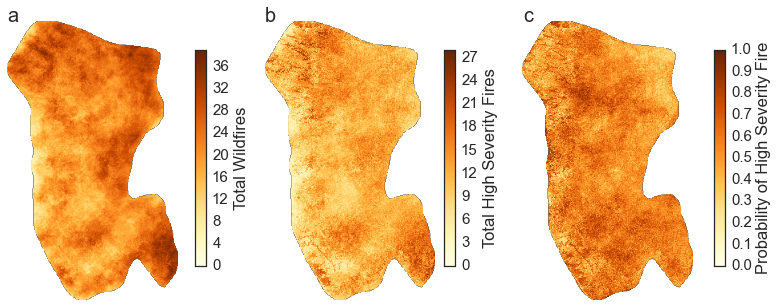

In [630]:
f, (ax1, ax2, ax3),  = plt.subplots(1,3, figsize =(15,5))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)
axx1 = plotRaster(totalFireMaps[0][SFF_Sims], cmap = 'YlOrBr', 
           vmin = 0, vmax = np.nanmax(totalFireMaps[0][SFF_Sims]), ax = ax1)
plotRaster(totalHSFireMaps[0][SFF_Sims], cmap = 'YlOrBr',
           vmin = 0, vmax = np.nanmax(totalHSFireMaps[0][SFF_Sims]), ax = ax2)
plotRaster(pHS_FireMaps[0][SFF_Sims], cmap = 'YlOrBr', 
           vmin = 0, vmax = 1, ax = ax3)

cbar1 = ax1.imshow(totalFireMaps[0][SFF_Sims] ,cmap = 'YlOrBr', 
                   vmin = 0, vmax = np.nanmax(totalFireMaps[0][SFF_Sims]))
cbar2 = ax2.imshow(totalHSFireMaps[0][SFF_Sims], cmap = 'YlOrBr', 
                   vmin = 0, vmax = np.nanmax(totalHSFireMaps[0][SFF_Sims]))
cbar3 = ax3.imshow(pHS_FireMaps[0][SFF_Sims], cmap = 'YlOrBr', 
                   vmin = 0, vmax = 1)

cbar1_ax = f.add_axes([0.37, 0.22, 0.01, 0.60])
cbar_ax2 = f.add_axes([0.60, 0.22, 0.01, 0.6])
cbar_ax3 = f.add_axes([0.85, 0.22, 0.01, 0.6])

kk1 =  f.colorbar(cbar1, cax=cbar1_ax,  label = 'Total Wildfires')
kk2 =  f.colorbar(cbar2, cax=cbar_ax2,  label = 'Total High Severity Fires')
kk3 =  f.colorbar(cbar3, cax=cbar_ax3,  label = 'Probability of High Severity Fire')

ax1.text(0, .4, 'a',  fontsize=20)
ax2.text(1, .4, 'b',  fontsize=20)
ax3.text(2.1, .4, 'c', fontsize=20)

plt.savefig('Figure4.tif', bbox_inches='tight',dpi = 150)

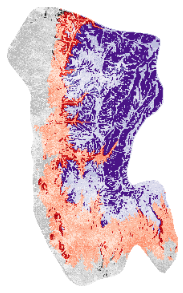

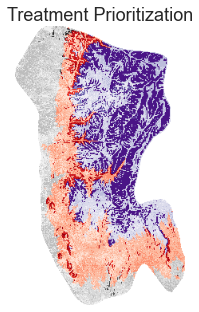

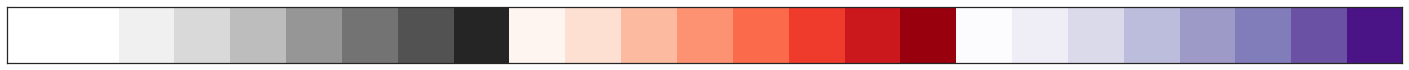

In [643]:
optMGMT = importRaster(rasters + 'SFF_Management_OPT.tif')

cmap = colors.ListedColormap(['white',
                              '#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525',
                              '#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d',
                              '#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#4a1486'])
mapcols = ['white',
                  '#ffffff','#f0f0f0','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525',
                  '#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#99000d',
                  '#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#4a1486']

mappal = sns.color_palette(mapcols).as_hex()

bounds=[0,
        100, 101, 102, 103, 150, 151, 152, 153,
        200, 201, 202, 203, 250, 251, 252, 253,
        300, 301, 302, 303, 350, 351, 352, 353]
norm  = colors.BoundaryNorm(bounds,  cmap.N)

f, ax1,  = plt.subplots(1,1, figsize =(5,5))
plotRaster(optMGMT, cmap = cmap,  norm = norm,  ax = ax1)
plt.savefig('Figure5_notitle.tif', bbox_inches='tight',dpi = 150)

f, ax1,  = plt.subplots(1,1, figsize =(5,5))
plotRaster(optMGMT, cmap = cmap,  norm = norm,  ax = ax1)
ax1.set_title('Treatment Prioritization')
plt.savefig('Figure5.tif', bbox_inches='tight',dpi = 150)

sns.palplot(mappal)

### Mean and variance of fire severity
Processed by taking the stacks of fire severity rasters and calculating a mean across them. Here, consistent with previous work, the means are only for cells that burn, creating a description of what the mean severity of a grid cell is, should it burn.

Likewise, the variance raster only takes into account the variance of fire severity for a given grid cell, when that grid cell burns.

In [160]:
sevmaps_mu = []
sevmaps_var = []


for sim in allSims:    
    sevrasters = severityStack(simsDir + sim + '/', 50)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevmaps_mu.append(sevmap)
    sevmaps_var.append(sevVarmap)

#### And the resulting figures

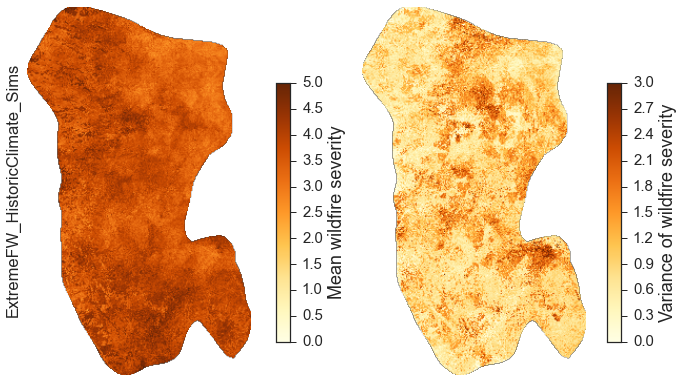

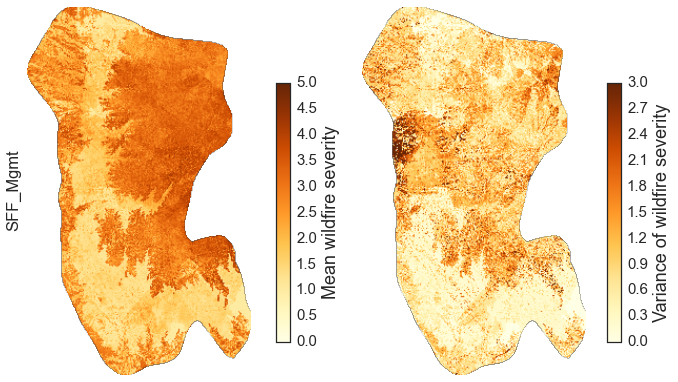

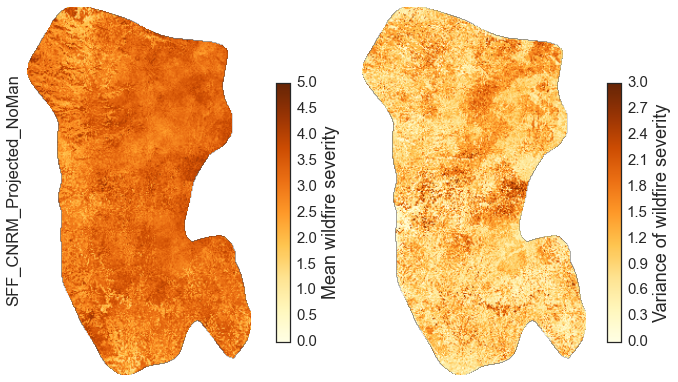

In [161]:
f, (ax, ax1) = plt.subplots(1,2, figsize =(10,8))
plt.subplots_adjust(wspace = 0.5)
plotRaster(sevmaps_mu[0][allSims[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax)
plotRaster(sevmaps_var[0][allSims[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax1)
ax.set_ylabel(allSims[0])

cbarmapmu = ax.imshow(sevmaps_mu[0][allSims[0]],   cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmapvar = ax1.imshow(sevmaps_var[0][allSims[0]], cmap = 'YlOrBr', vmin = 0, vmax = 3)

cbar_ax1 = f.add_axes([0.93, 0.25, 0.02, 0.45])
cbar_ax = f.add_axes([0.47, 0.25, 0.02, 0.45])

kk =  f.colorbar(cbarmapmu, cax=cbar_ax,  label = 'Mean wildfire severity')
kk1 = f.colorbar(cbarmapvar, cax=cbar_ax1, label = 'Variance of wildfire severity')

axCB = kk.ax
axCB1 = kk1.ax

text = axCB.yaxis.label
text1 = axCB1.yaxis.label

text.set_fontsize(18)
text1.set_fontsize(18)
sns.set_style('white')


f, (ax, ax1) = plt.subplots(1,2, figsize =(10,8))
plt.subplots_adjust(wspace = 0.5)
plotRaster(sevmaps_mu[1][allSims[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax)
plotRaster(sevmaps_var[1][allSims[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax1)
ax.set_ylabel(allSims[1])

cbarmapmu = ax.imshow(sevmaps_mu[1][allSims[1]],   cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmapvar = ax1.imshow(sevmaps_var[1][allSims[1]], cmap = 'YlOrBr', vmin = 0, vmax = 3)

cbar_ax1 = f.add_axes([0.93, 0.25, 0.02, 0.45])
cbar_ax = f.add_axes([0.47, 0.25, 0.02, 0.45])
#ax.set_ylable(allSims[1])
kk =  f.colorbar(cbarmapmu, cax=cbar_ax,  label = 'Mean wildfire severity')
kk1 = f.colorbar(cbarmapvar, cax=cbar_ax1, label = 'Variance of wildfire severity')

axCB = kk.ax
axCB1 = kk1.ax

text = axCB.yaxis.label
text1 = axCB1.yaxis.label

text.set_fontsize(18)
text1.set_fontsize(18)
sns.set_style('white')

f, (ax, ax1) = plt.subplots(1,2, figsize =(10,8))
plt.subplots_adjust(wspace = 0.5)
plotRaster(sevmaps_mu[2][allSims[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax)
plotRaster(sevmaps_var[2][allSims[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax1)
ax.set_ylabel(allSims[2])

cbarmapmu = ax.imshow(sevmaps_mu[2][allSims[2]],   cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmapvar = ax1.imshow(sevmaps_var[2][allSims[2]], cmap = 'YlOrBr', vmin = 0, vmax = 3)

cbar_ax1 = f.add_axes([0.93, 0.25, 0.02, 0.45])
cbar_ax = f.add_axes([0.47, 0.25, 0.02, 0.45])

kk =  f.colorbar(cbarmapmu, cax=cbar_ax,  label = 'Mean wildfire severity')
kk1 = f.colorbar(cbarmapvar, cax=cbar_ax1, label = 'Variance of wildfire severity')

axCB = kk.ax
axCB1 = kk1.ax

text = axCB.yaxis.label
text1 = axCB1.yaxis.label

text.set_fontsize(18)
text1.set_fontsize(18)
sns.set_style('white')



### The next fire output we can produce requires the fire logs
We can summarize a lot of info from the fire logs, like fire size distributions by mean fire severity, fire frequency, and some info about cohorts killed etc.

In [220]:
dffsLog = 'dynamic-fire-test-log.csv'
counter = 0
for simname in submitSims:
    reps = next(os.walk(simsDir + simname + '/'))[1]
    num_replicates = len(reps)

    for rep in reps:
        wkDir_c = simsDir + simname + '/' + rep + '/'
        repnum = rep.split('replicate')[1]
        if counter == 0:
            flogTot = pd.read_csv(wkDir_c + dffsLog, sep = ' ')
            flogTot['SIM'] = simname
            flogTot['REP'] = repnum
        else:           
            flog = pd.read_csv(wkDir_c + dffsLog, sep = ' ')
            flog['SIM'] = simname
            flog['REP'] = repnum
            flogTot = pd.concat([flogTot, flog])
        counter = counter + 1

flogTot[flogTot.TotalSitesInEvent <= 0].TotalSitesInEvent = np.nan
flogTot = flogTot.dropna()

AttributeError: 'DataFrame' object has no attribute 'TotalSitesInEvent'

### We can look at the mean replicate fire size by fire region
which is a rough approximation of the vegetation and fuels classes

In [217]:
flogTotMu = flogTot.groupby(['SIM','REP']).mean()

for sim in np.unique(flogTot.SIM):
    flogTotSim = flogTot[flogTot.SIM == sim]
    flogTotMu = flogTotSim.groupby('REP').mean()

    f, (ax1) = plt.subplots(1,1, figsize =(5,5))
    sns.distplot(np.log(flogTotMu['eco-200']), 
                 hist = False, kde = True,
                 color = 'orange',
                 bins = 10, ax = ax1, label = 'Pinon-Juniper')

    sns.distplot(np.log(flogTotMu['eco-300']), 
                 hist = False, kde = True,
                 color = 'green',
                 bins = 10, ax = ax1, label = 'Ponderosa Pine')

    sns.distplot(np.log(flogTotMu['eco-400']), 
                 hist = False, kde = True,
                 color = 'blue',
                 bins = 10, ax = ax1, label = 'Mixed Conifer')
    ax1.set_xlim([2,8])
    ax1.set_ylabel(sim)
    ax1.legend(loc = 0)
    ax1.set_xlabel('Natural log fire size (ha)')
    sns.despine()
    sns.set_style('ticks')
    sns.set_context('notebook', font_scale=1.5)

#### We can also ask questions about
how treatment affected fire size distributions in early, mid, or late century, which might be a useful thing to look at given the increasing fire weather severity in the simulations.

### We can do a lot with the Biomass rasters
The easiest thing to do is stack them up, and produce means and variances of biomass. by treatment, through time. We will look at early, mid, and late century biomass, aggregated by ecoregion, forest type, and the entire fireshed. 

Here I modified the severity stacking functions to query the biomass output rasters in PnEt. PnEt splits biomass by species, so for each replicate, we have to get the component species again and add them up. 

In [343]:
def bioStack(rasterLoc, year):
    bioList = []

    #rasterLoc = simsDir + submitSims[0] + '/'
    biomapname = 'biomass' + year + '.img'
    repnames = next(os.walk(rasterLoc))[1]
    for rep in repnames:

        repnum = rep.split('replicate')[1]
        wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/output/biomass/'
        specnames = next(os.walk(wkDir_data))[1]
        rasterlist = []

        for species in specnames:
            biomap = wkDir_data + species + '/' + biomapname
            src_ds = gdal.Open( biomap ) 

            bioarray = src_ds.ReadAsArray()
            bioarray = bioarray.astype('float')
            rasterlist.append(bioarray)   
        repBioStack = np.dstack(rasterlist)
        repBioSum   = np.nansum(repBioStack, axis = 2)
        bioList.append(repBioSum)
    return bioList

def bioGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    biomean = np.nanmean(rasterStack, axis = 2)
    return biomean



In [352]:
Nomgmt50 = bioStack(simsDir + submitSims[1] + '/','50')
Nomgmt50MU = bioGen(Nomgmt50)

Nomgmt20 = bioStack(simsDir + submitSims[1] + '/','20')
Nomgmt20MU = bioGen(Nomgmt20)    

mgmt50 = bioStack(simsDir + submitSims[0] + '/','50')
mgmt50MU = bioGen(mgmt50)

mgmt20 = bioStack(simsDir + submitSims[0] + '/','20')
mgmt20MU = bioGen(mgmt20)    

In [354]:
Nomgmt50MU = Nomgmt50MU * 0.5 * 0.6 * 0.01
Nomgmt20MU = Nomgmt20MU * 0.5 * 0.6 * 0.01
mgmt50MU  = mgmt50MU * 0.5 * 0.6 * 0.01
mgmt20MU  = mgmt20MU * 0.5 * 0.6 * 0.01

Nomgmt50MU[Nomgmt50MU == 0] = np.nan
Nomgmt20MU[Nomgmt20MU == 0] = np.nan
mgmt50MU[mgmt50MU == 0] = np.nan = np.nan
mgmt20MU[mgmt20MU == 0] = np.nan


In [511]:
meanDiff20 = ((mgmt20MU - Nomgmt20MU) / Nomgmt20MU) * 100
meanDiff50 = ((mgmt50MU - Nomgmt50MU) / Nomgmt50MU) * 100
np.nanmax(meanDiff20)

70.907300933374458

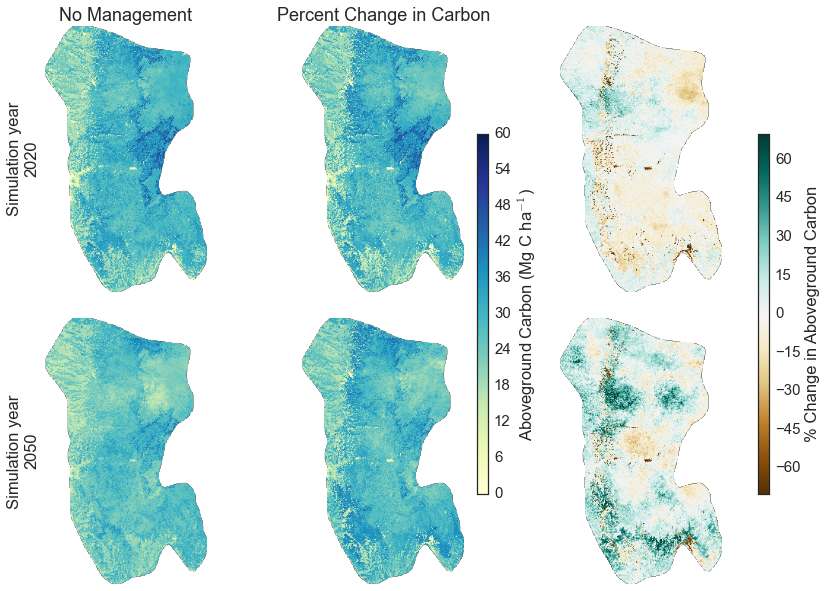

In [525]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(15,10))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)

plotRaster(Nomgmt20MU, ax = ax1)
plotRaster(mgmt20MU, ax = ax2)
plotRaster(Nomgmt50MU, ax = ax4)
plotRaster(mgmt50MU, ax = ax5)
plotRaster(meanDiff20, cmap = 'RdYlBu',ax = ax3, vmin = -30, vmax = 30)
plotRaster(meanDiff50, cmap = 'RdYlBu',ax = ax6, vmin = np.nanmin(meanDiff50), vmax = np.nanmax(meanDiff50))

nomgmt = ax1.imshow(Nomgmt20MU,cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax2.imshow(mgmt20MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax4.imshow(Nomgmt50MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax5.imshow(mgmt50MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)
perdiff = ax3.imshow(meanDiff20, cmap = 'BrBG', vmin = -70, vmax = 70)
ax6.imshow(meanDiff50, cmap = 'BrBG', vmin = -70, vmax = 70)

cbar_ax1 = f.add_axes([0.60, 0.25, 0.01, 0.5])
cbar_ax2 = f.add_axes([0.86, 0.25, 0.01, 0.5])

kk =  f.colorbar(nomgmt, cax=cbar_ax1,  label = 'Aboveground Carbon (Mg C ha$^{-1}$)')
kk2 =  f.colorbar(perdiff, cax=cbar_ax2,  label = '% Change in Aboveground Carbon')

ax1.set_title('No Management')
ax2.set_title('Treatment Placement')
ax2.set_title('Percent Change in Carbon')

ax1.set_ylabel('Simulation year \n2020')
ax4.set_ylabel('Simulation year \n2050')

sns.set_style('white')
plt.savefig('Biomass.tif',bbox_inches='tight',dpi = 150)


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize =(10,10))

plt.subplots_adjust(wspace = -.2, hspace = 0.1)
plotRaster(Nomgmt20MU, ax = ax1)
plotRaster(mgmt20MU, ax = ax2)
plotRaster(Nomgmt50MU, ax = ax3)
plotRaster(mgmt50MU, ax = ax4)

nomgmt = ax1.imshow(Nomgmt20MU,cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax2.imshow(mgmt20MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax3.imshow(Nomgmt50MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)
ax4.imshow(mgmt50MU, cmap = 'YlGnBu', vmin = 0, vmax = 60)

cbar_ax1 = f.add_axes([0.90, 0.25, 0.02, 0.5])
kk =  f.colorbar(nomgmt, cax=cbar_ax1,  label = 'Above Ground Biomass (Mg C ha$^{-1}$)')

ax1.set_title('2020')
ax2.set_title('2050')
ax1.set_ylabel('No Management')
ax3.set_ylabel('Treatmnet Placement')

sns.set_style('white')
plt.savefig('Biomass.tif', dpi = 150)


In [485]:
meanDiff = ((sevmaps_mu[1][allSims[1]] - sevmaps_mu[2][allSims[2]]) / sevmaps_mu[2][allSims[2]]) * 100
meanDiffvar = ((sevmaps_var[2][allSims[2]] - sevmaps_var[1][allSims[1]]) / sevmaps_var[2][allSims[2]]) * 100

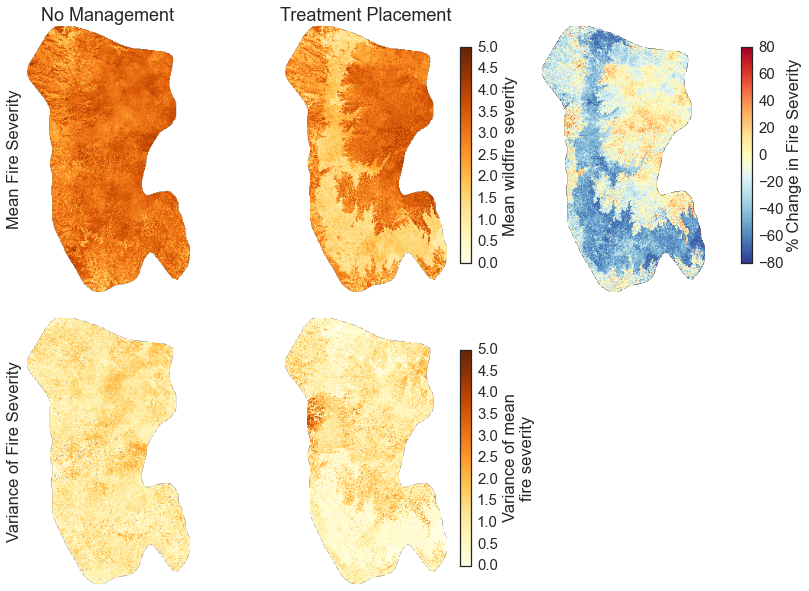

In [526]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(15,10))
plt.subplots_adjust(wspace = -.2, hspace = 0.1)
plotRaster(sevmaps_mu[2][allSims[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax1)
plotRaster(sevmaps_mu[1][allSims[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax2)
plotRaster(meanDiff, cmap = 'RdYlBu',ax = ax3, vmin = np.nanmin(meanDiff), vmax = np.nanmax(meanDiff))
perchange = ax3.imshow(meanDiff, cmap = 'RdYlBu_r',vmin = -80, vmax = 80)
f.delaxes(ax6)

plotRaster(sevmaps_var[2][allSims[2]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax4)
plotRaster(sevmaps_var[1][allSims[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax5)

cbar_ax2 = f.add_axes([0.60, 0.57, 0.01, 0.3])
cbar_ax3 = f.add_axes([0.86, 0.57, 0.01, 0.3])
cbar_ax5 = f.add_axes([0.60, 0.15, 0.01, 0.3])

kk2 =  f.colorbar(cbarmapmu, cax=cbar_ax2,  label = 'Mean wildfire severity')
kk3 =  f.colorbar(perchange, cax=cbar_ax3,  label = '% Change in Fire Severity')
kk5 =  f.colorbar(cbarmapmu, cax=cbar_ax5,  label = 'Variance of mean \nfire severity')

ax1.set_title('No Management')
ax2.set_title('Treatment Placement')
ax1.set_ylabel('Mean Fire Severity')
ax4.set_ylabel('Variance of Fire Severity')
plt.savefig('FireSev.tif',bbox_inches='tight',dpi = 150)

### There are also summary time series by ecoregion, and by landscape
for each chosen output variable. Looks very promising as a means to produce quick time series. 